### Задание 1

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("CovidDataAnalysis") \
    .getOrCreate()

df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("covid_data.csv")

df.printSchema()
df.show(5)

25/01/22 14:24:47 WARN Utils: Your hostname, MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.101.37 instead (on interface en0)
25/01/22 14:24:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/22 14:24:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- Province/State: string (nullable = true)
 |-- Country/Region: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Long: double (nullable = true)
 |-- Date: date (nullable = true)
 |-- Confirmed: integer (nullable = true)
 |-- Deaths: integer (nullable = true)
 |-- Recovered: integer (nullable = true)
 |-- Active: integer (nullable = true)
 |-- WHO Region: string (nullable = true)

+--------------+--------------+--------+---------+----------+---------+------+---------+------+--------------------+
|Province/State|Country/Region|     Lat|     Long|      Date|Confirmed|Deaths|Recovered|Active|          WHO Region|
+--------------+--------------+--------+---------+----------+---------+------+---------+------+--------------------+
|          NULL|   Afghanistan|33.93911|67.709953|2020-01-22|        0|     0|        0|     0|Eastern Mediterra...|
|          NULL|       Albania| 41.1533|  20.1683|2020-01-22|        0|     0|        0|     0|              Europe|
|       

In [11]:
# Оставим только записи по Афганистану
afg_df = df.filter(df["Country/Region"] == "Afghanistan")
afg_df.show(5)

+--------------+--------------+--------+---------+----------+---------+------+---------+------+--------------------+
|Province/State|Country/Region|     Lat|     Long|      Date|Confirmed|Deaths|Recovered|Active|          WHO Region|
+--------------+--------------+--------+---------+----------+---------+------+---------+------+--------------------+
|          NULL|   Afghanistan|33.93911|67.709953|2020-01-22|        0|     0|        0|     0|Eastern Mediterra...|
|          NULL|   Afghanistan|33.93911|67.709953|2020-01-23|        0|     0|        0|     0|Eastern Mediterra...|
|          NULL|   Afghanistan|33.93911|67.709953|2020-01-24|        0|     0|        0|     0|Eastern Mediterra...|
|          NULL|   Afghanistan|33.93911|67.709953|2020-01-25|        0|     0|        0|     0|Eastern Mediterra...|
|          NULL|   Afghanistan|33.93911|67.709953|2020-01-26|        0|     0|        0|     0|Eastern Mediterra...|
+--------------+--------------+--------+---------+----------+---

In [12]:
# Оставим только часть столбцов (Date и Confirmed):
afg_confirmed = afg_df.select("Date", "Confirmed")
afg_confirmed.show(5)

+----------+---------+
|      Date|Confirmed|
+----------+---------+
|2020-01-22|        0|
|2020-01-23|        0|
|2020-01-24|        0|
|2020-01-25|        0|
|2020-01-26|        0|
+----------+---------+
only showing top 5 rows



In [13]:
# Суммарное количество подтвержденных случаев по каждой стране
from pyspark.sql.functions import max, sum

max_date = df.select(max("Date")).collect()[0][0]

latest_df = df.filter(df["Date"] == max_date)

summary_df = latest_df.groupBy("Country/Region") \
    .agg(
        sum("Confirmed").alias("total_confirmed"),
        sum("Deaths").alias("total_deaths")
    ) \
    .orderBy("total_confirmed", ascending=False)

summary_df.show(10)

+--------------+---------------+------------+
|Country/Region|total_confirmed|total_deaths|
+--------------+---------------+------------+
|            US|        4290259|      148011|
|        Brazil|        2442375|       87618|
|         India|        1480073|       33408|
|        Russia|         816680|       13334|
|  South Africa|         452529|        7067|
|        Mexico|         395489|       44022|
|          Peru|         389717|       18418|
|         Chile|         347923|        9187|
|United Kingdom|         301708|       45844|
|          Iran|         293606|       15912|
+--------------+---------------+------------+
only showing top 10 rows



### Задание 2

In [29]:
# Удалим строки, где Lat или Long равны null
df_no_nulls = df.dropna(subset=["Province/State"])

# Заполним пропущенные значения в Confirmed нулями
df_filled = df.na.fill({"Confirmed": 0})

df.show(5)
print("Кол-во до фильтрации", df.count())

df_no_nulls.show(5)
print("Кол-во после фильтрации", df_no_nulls.count())

+--------------+--------------+--------+---------+----------+---------+------+---------+------+--------------------+
|Province/State|Country/Region|     Lat|     Long|      Date|Confirmed|Deaths|Recovered|Active|          WHO Region|
+--------------+--------------+--------+---------+----------+---------+------+---------+------+--------------------+
|          NULL|   Afghanistan|33.93911|67.709953|2020-01-22|        0|     0|        0|     0|Eastern Mediterra...|
|          NULL|       Albania| 41.1533|  20.1683|2020-01-22|        0|     0|        0|     0|              Europe|
|          NULL|       Algeria| 28.0339|   1.6596|2020-01-22|        0|     0|        0|     0|              Africa|
|          NULL|       Andorra| 42.5063|   1.5218|2020-01-22|        0|     0|        0|     0|              Europe|
|          NULL|        Angola|-11.2027|  17.8739|2020-01-22|        0|     0|        0|     0|              Africa|
+--------------+--------------+--------+---------+----------+---

In [20]:
from pyspark.sql.functions import to_date

df = df.withColumn("Date", to_date(df["Date"], "yyyy-MM-dd"))
df.show(5)

+--------------+--------------+--------+---------+----------+---------+------+---------+------+--------------------+
|Province/State|Country/Region|     Lat|     Long|      Date|Confirmed|Deaths|Recovered|Active|          WHO Region|
+--------------+--------------+--------+---------+----------+---------+------+---------+------+--------------------+
|          NULL|   Afghanistan|33.93911|67.709953|2020-01-22|        0|     0|        0|     0|Eastern Mediterra...|
|          NULL|       Albania| 41.1533|  20.1683|2020-01-22|        0|     0|        0|     0|              Europe|
|          NULL|       Algeria| 28.0339|   1.6596|2020-01-22|        0|     0|        0|     0|              Africa|
|          NULL|       Andorra| 42.5063|   1.5218|2020-01-22|        0|     0|        0|     0|              Europe|
|          NULL|        Angola|-11.2027|  17.8739|2020-01-22|        0|     0|        0|     0|              Africa|
+--------------+--------------+--------+---------+----------+---

In [32]:
# Очистим дубликаты
df_no_dups = df.dropDuplicates(["Country/Region", "Date"])

print("Всего:", df.count())
print("Всего без дубликатов:", df_no_dups.count())

Всего: 49068
Всего без дубликатов: 35156


### Задание 3

In [31]:
# Общая статистика
df.describe(["Confirmed", "Deaths", "Recovered"]).show()

+-------+------------------+-----------------+-----------------+
|summary|         Confirmed|           Deaths|        Recovered|
+-------+------------------+-----------------+-----------------+
|  count|             49068|            49068|            49068|
|   mean| 16884.90425531915|884.1791595337083|7915.713479253282|
| stddev|127300.20527228026|6313.584410596534|54800.91873054013|
|    min|                 0|                0|                0|
|    max|           4290259|           148011|          1846641|
+-------+------------------+-----------------+-----------------+



In [ ]:
# В каких странах чаще всего встречается
from pyspark.sql.functions import sum

country_confirmed = df.groupBy("Country/Region") \
                    .agg(sum("Confirmed").alias("sum_confirmed")) \
                    .orderBy("sum_confirmed", ascending=False)

country_confirmed.show(10)

+--------------+-------------+
|Country/Region|sum_confirmed|
+--------------+-------------+
|            US|    224345948|
|        Brazil|     89524967|
|        Russia|     45408411|
|         India|     40883464|
|         Spain|     27404045|
|United Kingdom|     26748587|
|         Italy|     26745145|
|        France|     21210926|
|       Germany|     21059152|
|          Iran|     19339267|
+--------------+-------------+
only showing top 10 rows



In [35]:
# Динамика количества встречающихся случаев
daily_df = df.groupBy("Date") \
            .agg(sum("Confirmed").alias("total_confirmed_world")) \
            .orderBy("Date")

daily_df.show(10)

+----------+---------------------+
|      Date|total_confirmed_world|
+----------+---------------------+
|2020-01-22|                  555|
|2020-01-23|                  654|
|2020-01-24|                  941|
|2020-01-25|                 1434|
|2020-01-26|                 2118|
|2020-01-27|                 2927|
|2020-01-28|                 5578|
|2020-01-29|                 6166|
|2020-01-30|                 8234|
|2020-01-31|                 9927|
+----------+---------------------+
only showing top 10 rows



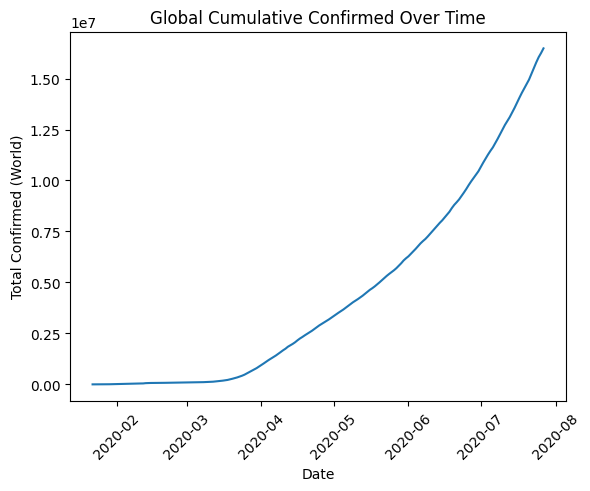

In [47]:
pdf_daily = daily_df.toPandas()

import matplotlib.pyplot as plt

plt.plot(pdf_daily["Date"], pdf_daily["total_confirmed_world"])
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Total Confirmed (World)")
plt.title("Global Cumulative Confirmed Over Time")
plt.show()

In [44]:
# Показатели по регионам
region_df = df.groupBy("WHO Region") \
            .agg(
                    sum("Confirmed").alias("sum_confirmed"),
                    sum("Deaths").alias("sum_deaths")
                ) \
            .orderBy("sum_confirmed", ascending=False)
region_df.show()

+--------------------+-------------+----------+
|          WHO Region|sum_confirmed|sum_deaths|
+--------------------+-------------+----------+
|            Americas|    402261194|  19359292|
|              Europe|    248879793|  19271040|
|Eastern Mediterra...|     74082892|   1924029|
|     South-East Asia|     55118365|   1458134|
|     Western Pacific|     26374411|    932430|
|              Africa|     21791827|    439978|
+--------------------+-------------+----------+



### Задание 4

In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("KafkaStreamExample") \
    .config("spark.jars.repositories", "https://repo1.maven.org/maven2/") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.4") \
    .getOrCreate()

df_stream = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "test_topic") \
    .option("startingOffsets", "latest") \
    .load()

25/01/22 14:30:16 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


AnalysisException: Failed to find data source: kafka. Please deploy the application as per the deployment section of Structured Streaming + Kafka Integration Guide.

3.5.4
